In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pylab as plt

from image_analysis.read_files import get_paths, change_paths
from image_analysis.fit import plot, roi
from image_analysis.preprocess import mask

In [3]:
pixel_size = 2

In [4]:
folder_pretreated = r'/home/natalia/Documents/github_image_analysis/experimental_data/treatment_all/'
df = pd.read_excel("../overview_excel_tables/excel_tables/image_analysis_summary_final.xlsx")

In [5]:
df

,initial_file,hcr_expriment,pretreated_file_name,animal_size,time,shh_segm,fgf_segm,dusp_segm
0,/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_...,11,hcr11_lb27_fl,1.5,1.0,yes,yes,yes
1,/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_...,11,hcr11_lb28_fr,1.5,1.0,yes,yes,yes
2,/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_...,11,hcr11_5cmbl_8d,5.0,8.0,yes,yes,no
3,/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_...,11,hcr11_5cmbl_10d,5.0,10.0,yes,yes,yes
4,/20221024_hcr11_lsm_fgf8_547_shh_647_dusp_750_...,11,hcr11_lb28_fl,1.5,1.0,yes,yes,yes
...,...,...,...,...,...,...,...,...
62,/hcr23/5cm_dusp_gfp/hcr23_20241004_5cm_an14066...,23,hcr23_5cm_an14066_6d_fr,5.0,6.0,yes,yes,yes
63,/hcr23/lb/hcr23_20240927_lb79_fl_t4a#1.lif,23,hcr23_lb79_fl,1.5,1.0,yes,yes,yes
64,/hcr23/lb/hcr23_20240927_lb80_fl_t4a#2_dd.lif,23,hcr23_lb80_fl,1.5,1.0,yes,yes,yes
65,/hcr23/lb/hcr23_20240927_lb76_fl_t1#4.lif,23,hcr23_lb76_fl,1.5,1.0,yes,yes,yes


# 2.5 cm blastemas

In [6]:
df_to_plot = df[df['animal_size'] == 2.5]

In [7]:
df_to_plot['time'] = np.array(df_to_plot['time']).astype(int)

/tmp/ipykernel_4849/3232859577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['time'] = np.array(df_to_plot['time']).astype(int)


In [8]:
len(df_to_plot)

8

In [9]:
keys_dpa = set( [str(h) for h in df_to_plot['time'].values] )
keys_dpa

{'4', '5', '6', '7'}

In [10]:
img = dict.fromkeys(keys_dpa, 0)

for tkey in keys_dpa:
    
    df_t  = df_to_plot[df_to_plot['time'] == int(tkey)]
    df_t  = df_t.reset_index(drop=True)
    nkeys = [str(i+1) for i in range(0, len(df_t))]
    img[tkey]  = dict.fromkeys(nkeys, 0)

    for index, row in df_t.iterrows():
        
        path = row['pretreated_file_name']
        keys = np.load( os.path.join(folder_pretreated, path + '_keys.npy') )
        
        img_morph = dict(
            zip(
                keys, 
                np.load( os.path.join(folder_pretreated, path + '.npy') )
            )
        )

        for key in keys:
            if 'shh50_clip' in key:
                img_morph[key] = img_morph[key] * mask.largest_component( img_morph[key] > 0 )
            elif ('fgf50_clip' in key) or ('dusp50_clip' in key):
                img_morph[key] = img_morph[key] * mask.few_largest_components( img_morph[key] > 0, 2 )
            

        # total projection
        for key in img_morph.keys():
            img_morph[key] = roi.mean_nonzero( img_morph[key], 0)
            
            if 'mask' in key:
                img_morph[key] = (img_morph[key] > 0) * 1
        
        img[tkey][str(index+1)] = dict(zip([path], [img_morph]))

/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/roi.py:196: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(arr, axis=axis_n)
/home/natalia/Documents/github_image_analysis/image_analysis/image_analysis/fit/roi.py:198: RuntimeWarning: invalid value encountered in cast
  return arr.astype( np.uint16 )


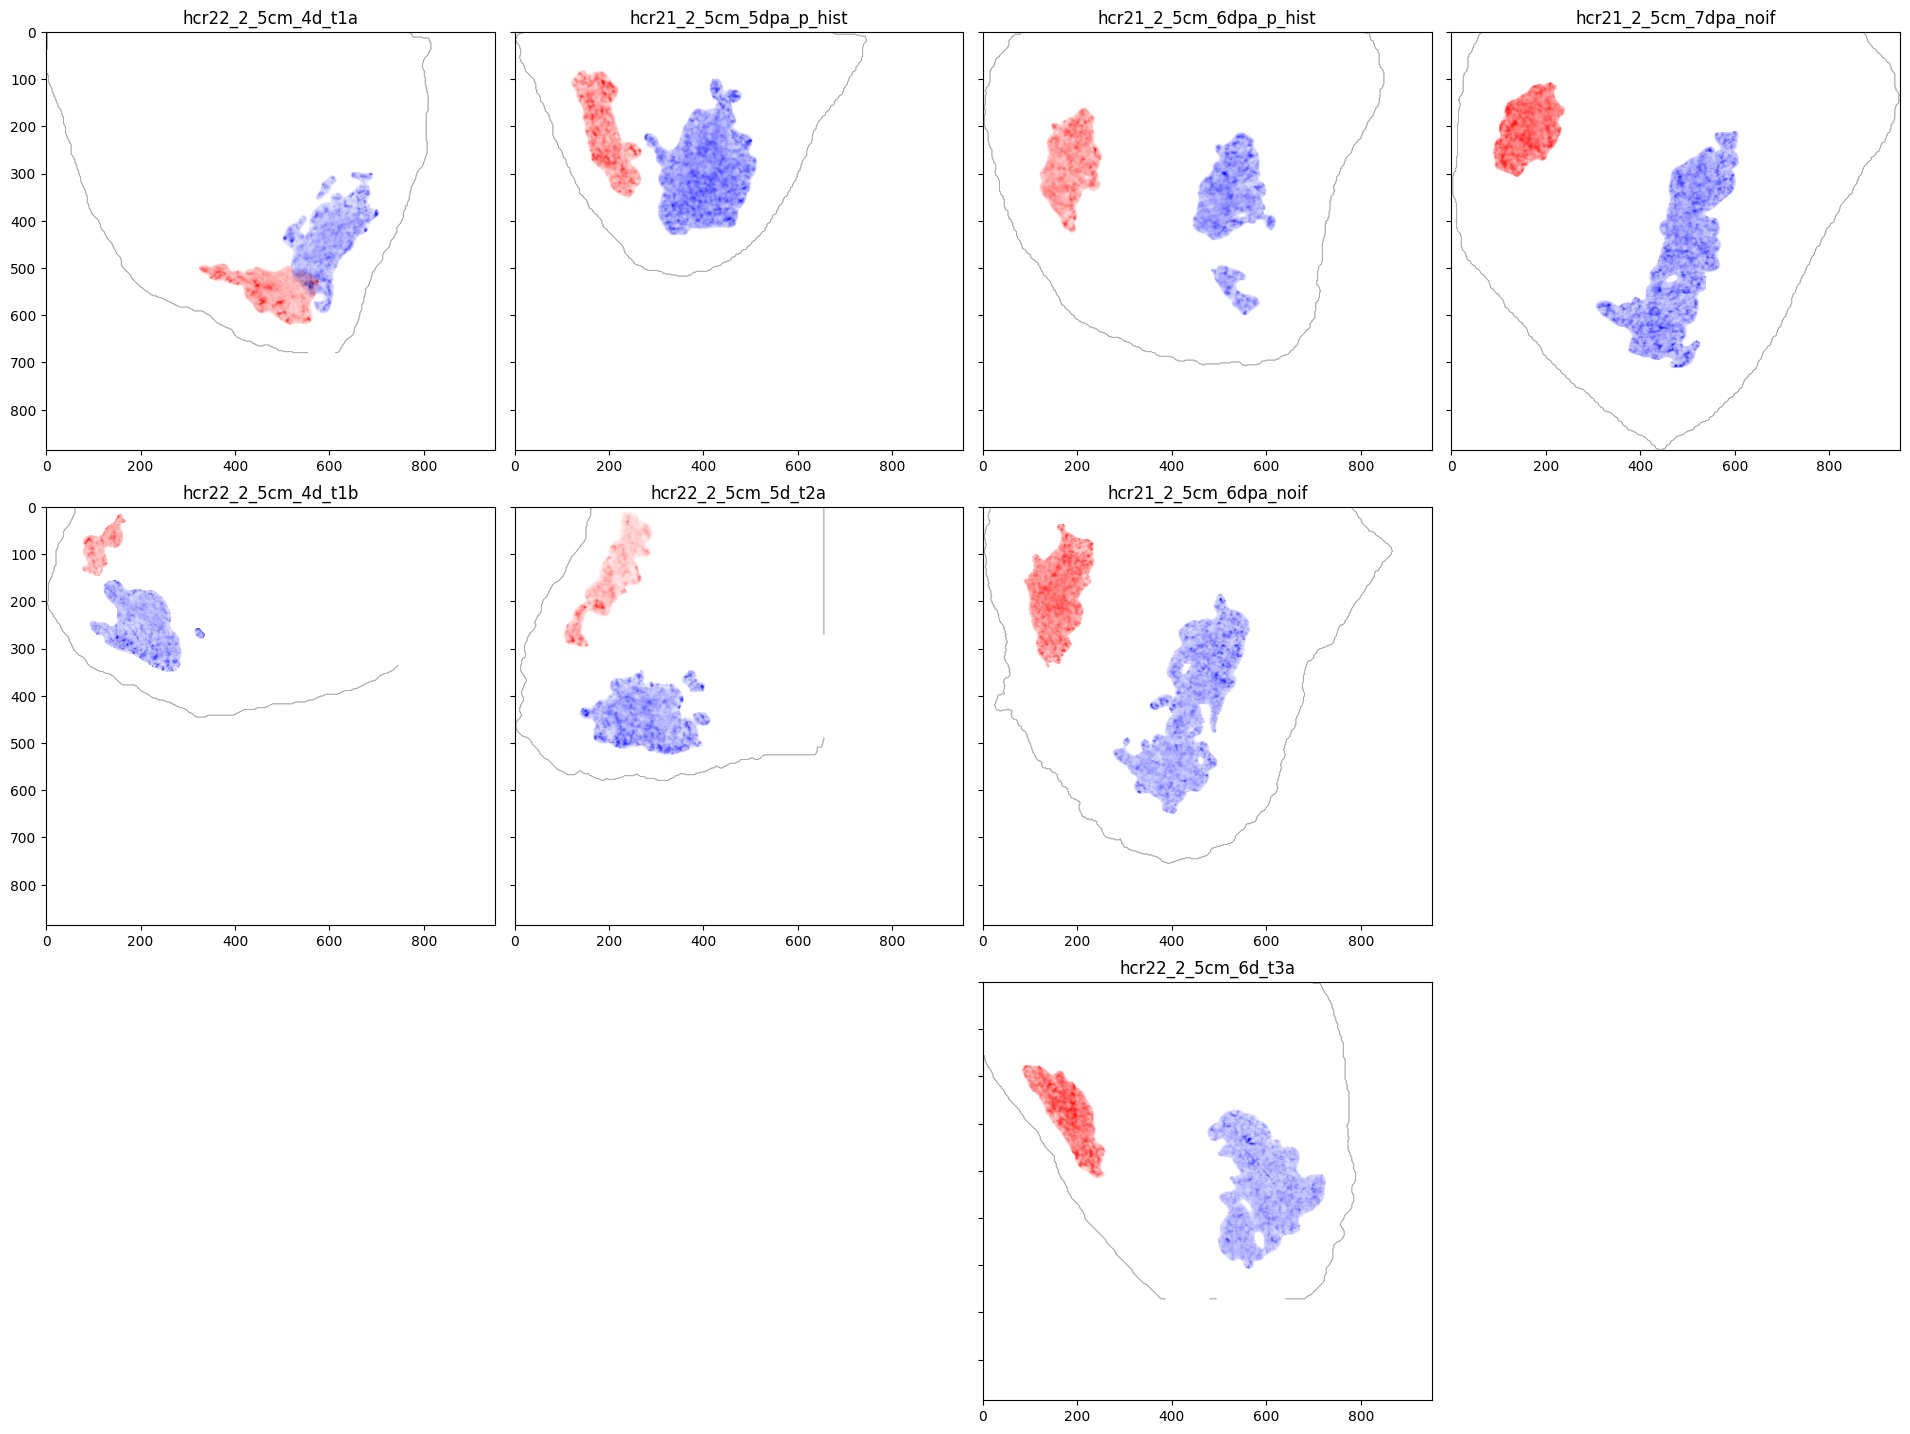

In [11]:
plot.shh_fgf_red_blue(img, pixel_size, 'shh50_clip', 'fgf50_clip', 100)
#plt.savefig('preview/2_5cm_blastemas_overlay.pdf')
plt.show()

In [12]:
tkey, nkey = '4', '1'
for file_name in img[tkey][nkey].keys():
    for key in img[tkey][nkey][file_name].keys():
        img[tkey][nkey][file_name][key] = img[tkey][nkey][file_name][key][:, :220]

In [13]:
tkey, nkey = '4', '2'
for file_name in img[tkey][nkey].keys():
    for key in img[tkey][nkey][file_name].keys():
        img[tkey][nkey][file_name][key] = img[tkey][nkey][file_name][key][130:, :]
        img[tkey][nkey][file_name][key] = img[tkey][nkey][file_name][key][:, 80:]    

In [14]:
tkey, nkey = '5', '2'
for file_name in img[tkey][nkey].keys():
    for key in img[tkey][nkey][file_name].keys():
        img[tkey][nkey][file_name][key] = img[tkey][nkey][file_name][key][:, :320]

In [15]:
tkey, nkey = '6', '1'
for file_name in img[tkey][nkey].keys():
    for key in img[tkey][nkey][file_name].keys():
        #img[tkey][nkey][file_name][key] = img[tkey][nkey][file_name][key][20:, :]
        img[tkey][nkey][file_name][key] = img[tkey][nkey][file_name][key][:, :370]

In [16]:
tkey, nkey = '6', '2'
for file_name in img[tkey][nkey].keys():
    for key in img[tkey][nkey][file_name].keys():
        img[tkey][nkey][file_name][key] = img[tkey][nkey][file_name][key][30:, :]

In [17]:
tkey, nkey = '7', '1'
for file_name in img[tkey][nkey].keys():
    for key in img[tkey][nkey][file_name].keys():
        img[tkey][nkey][file_name][key] = img[tkey][nkey][file_name][key][1:, :]
        img[tkey][nkey][file_name][key] = img[tkey][nkey][file_name][key][:, :440]

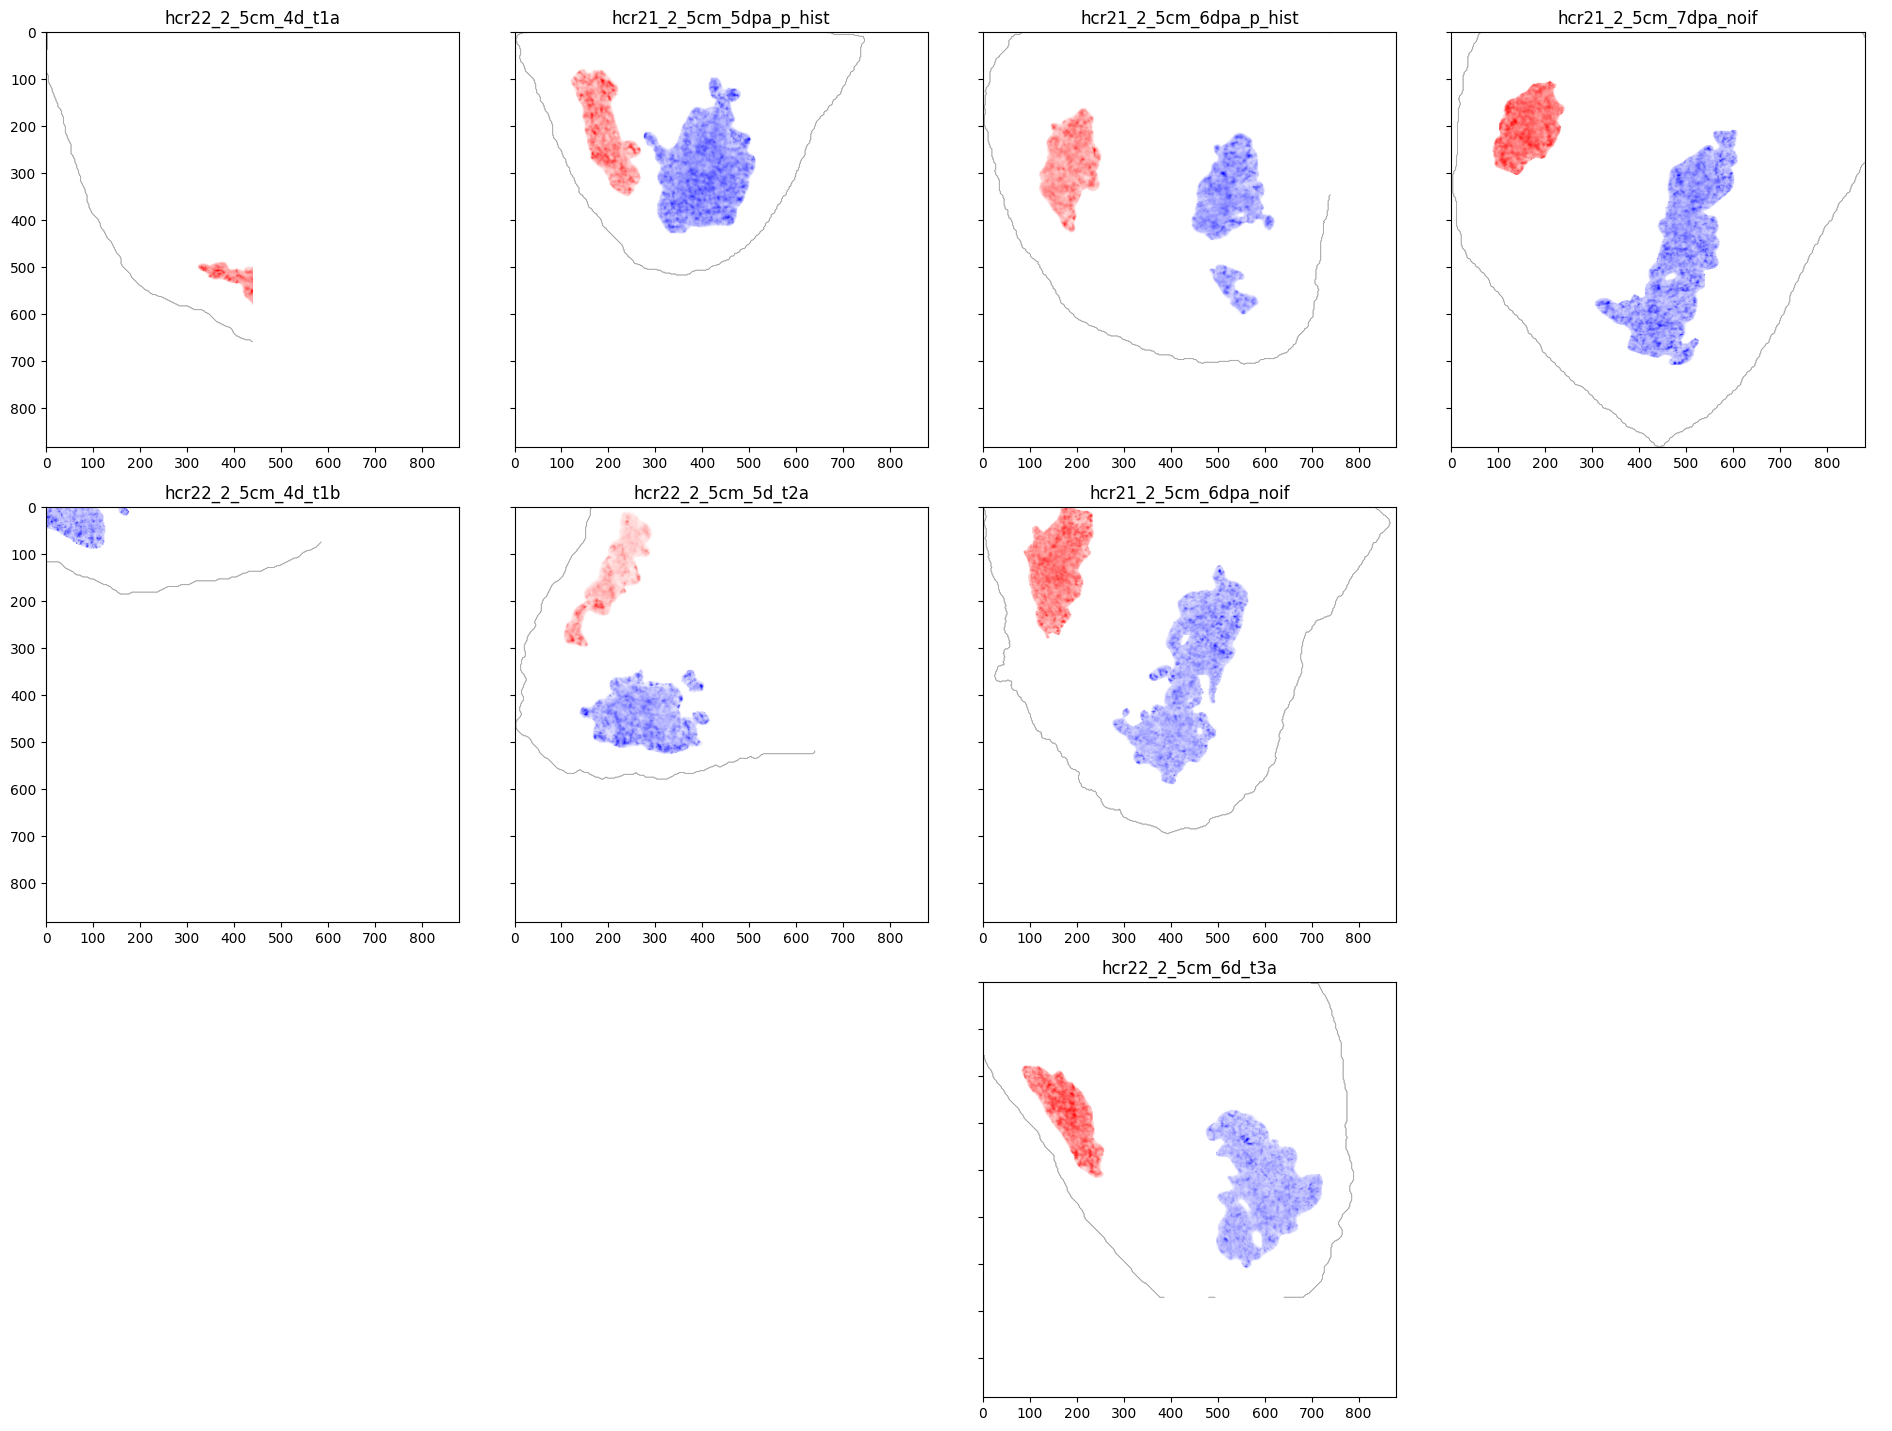

In [18]:
plot.shh_fgf_red_blue(img, pixel_size, 'shh50_clip', 'fgf50_clip', 100)
#plt.savefig('preview/2_5cm_blastemas_overlay.pdf')
plt.show()

## Useful function

In [19]:
from skimage.morphology import binary_opening, binary_closing, disk
from scipy.ndimage import binary_fill_holes, gaussian_filter
import copy

In [20]:
selem = disk(radius=5)

In [21]:
def take_contour_vert_from_mask(tissue_mask, pixel_size=pixel_size):
    tissue_mask = binary_fill_holes( binary_closing( binary_opening( tissue_mask.astype(np.uint8), selem ), selem ) )
    tissue_mask = mask.largest_component(tissue_mask)

    # Create a dummy figure and axes to suppress plotting
    fig, ax = plt.subplots()
    mask_contour = ax.contour(tissue_mask,  extent=[0, tissue_mask.shape[1]*pixel_size, 0, tissue_mask.shape[0]*pixel_size])
    path = mask_contour.get_paths()[0]
    vert = path.vertices
    
    # Close the figure to suppress display
    plt.close(fig)
    return resample_contour(vert, num_points=100)

In [22]:
def resample_contour(vertices, num_points=100):
    # Calculate the cumulative distances along the contour
    distances = np.sqrt(np.sum(np.diff(vertices, axis=0)**2, axis=1))
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)

    # Interpolation functions for x and y coordinates
    interp_x = interp1d(cumulative_distances, vertices[:, 0], kind='linear')
    interp_y = interp1d(cumulative_distances, vertices[:, 1], kind='linear')

    # Generate equally spaced distances along the contour
    uniform_distances = np.linspace(0, cumulative_distances[-1], num_points)

    # Resample the contour to get uniformly spaced points
    resampled_vertices = np.vstack((interp_x(uniform_distances), interp_y(uniform_distances))).T
    
    return resampled_vertices

In [23]:
n = 10
img_new = copy.deepcopy(img)

for tkey in img.keys():
    for nkey in img[tkey].keys():
        for file_name in img[tkey][nkey].keys():        
            for key in img[tkey][nkey][file_name].keys():
                j, i = img[tkey][nkey][file_name][key].shape
                img_new[tkey][nkey][file_name][key] = np.zeros((j+n, i))
                img_new[tkey][nkey][file_name][key][:-n, :] = img[tkey][nkey][file_name][key]

img = img_new
del img_new

In [24]:
x_lim, y_lim = 0, 0
for tkey in img.keys():
    for nkey in img[tkey].keys():
        for file_name in img[tkey][nkey].keys():        
            x_lim_n = img[tkey][nkey][file_name]['tissue_mask'].shape[1]
            y_lim_n = img[tkey][nkey][file_name]['tissue_mask'].shape[0]
            if x_lim < x_lim_n:
                x_lim = x_lim_n
            if y_lim < y_lim_n:
                y_lim = y_lim_n

In [25]:
tkeys = []
for tkey in img.keys():
    tkeys.append( int(tkey)  )
tkeys = (np.sort( np.array(tkeys) )).astype(str)

## Contours

In [26]:
shh_morph = 'shh50_clip'
fgf_morph = 'fgf50_clip'

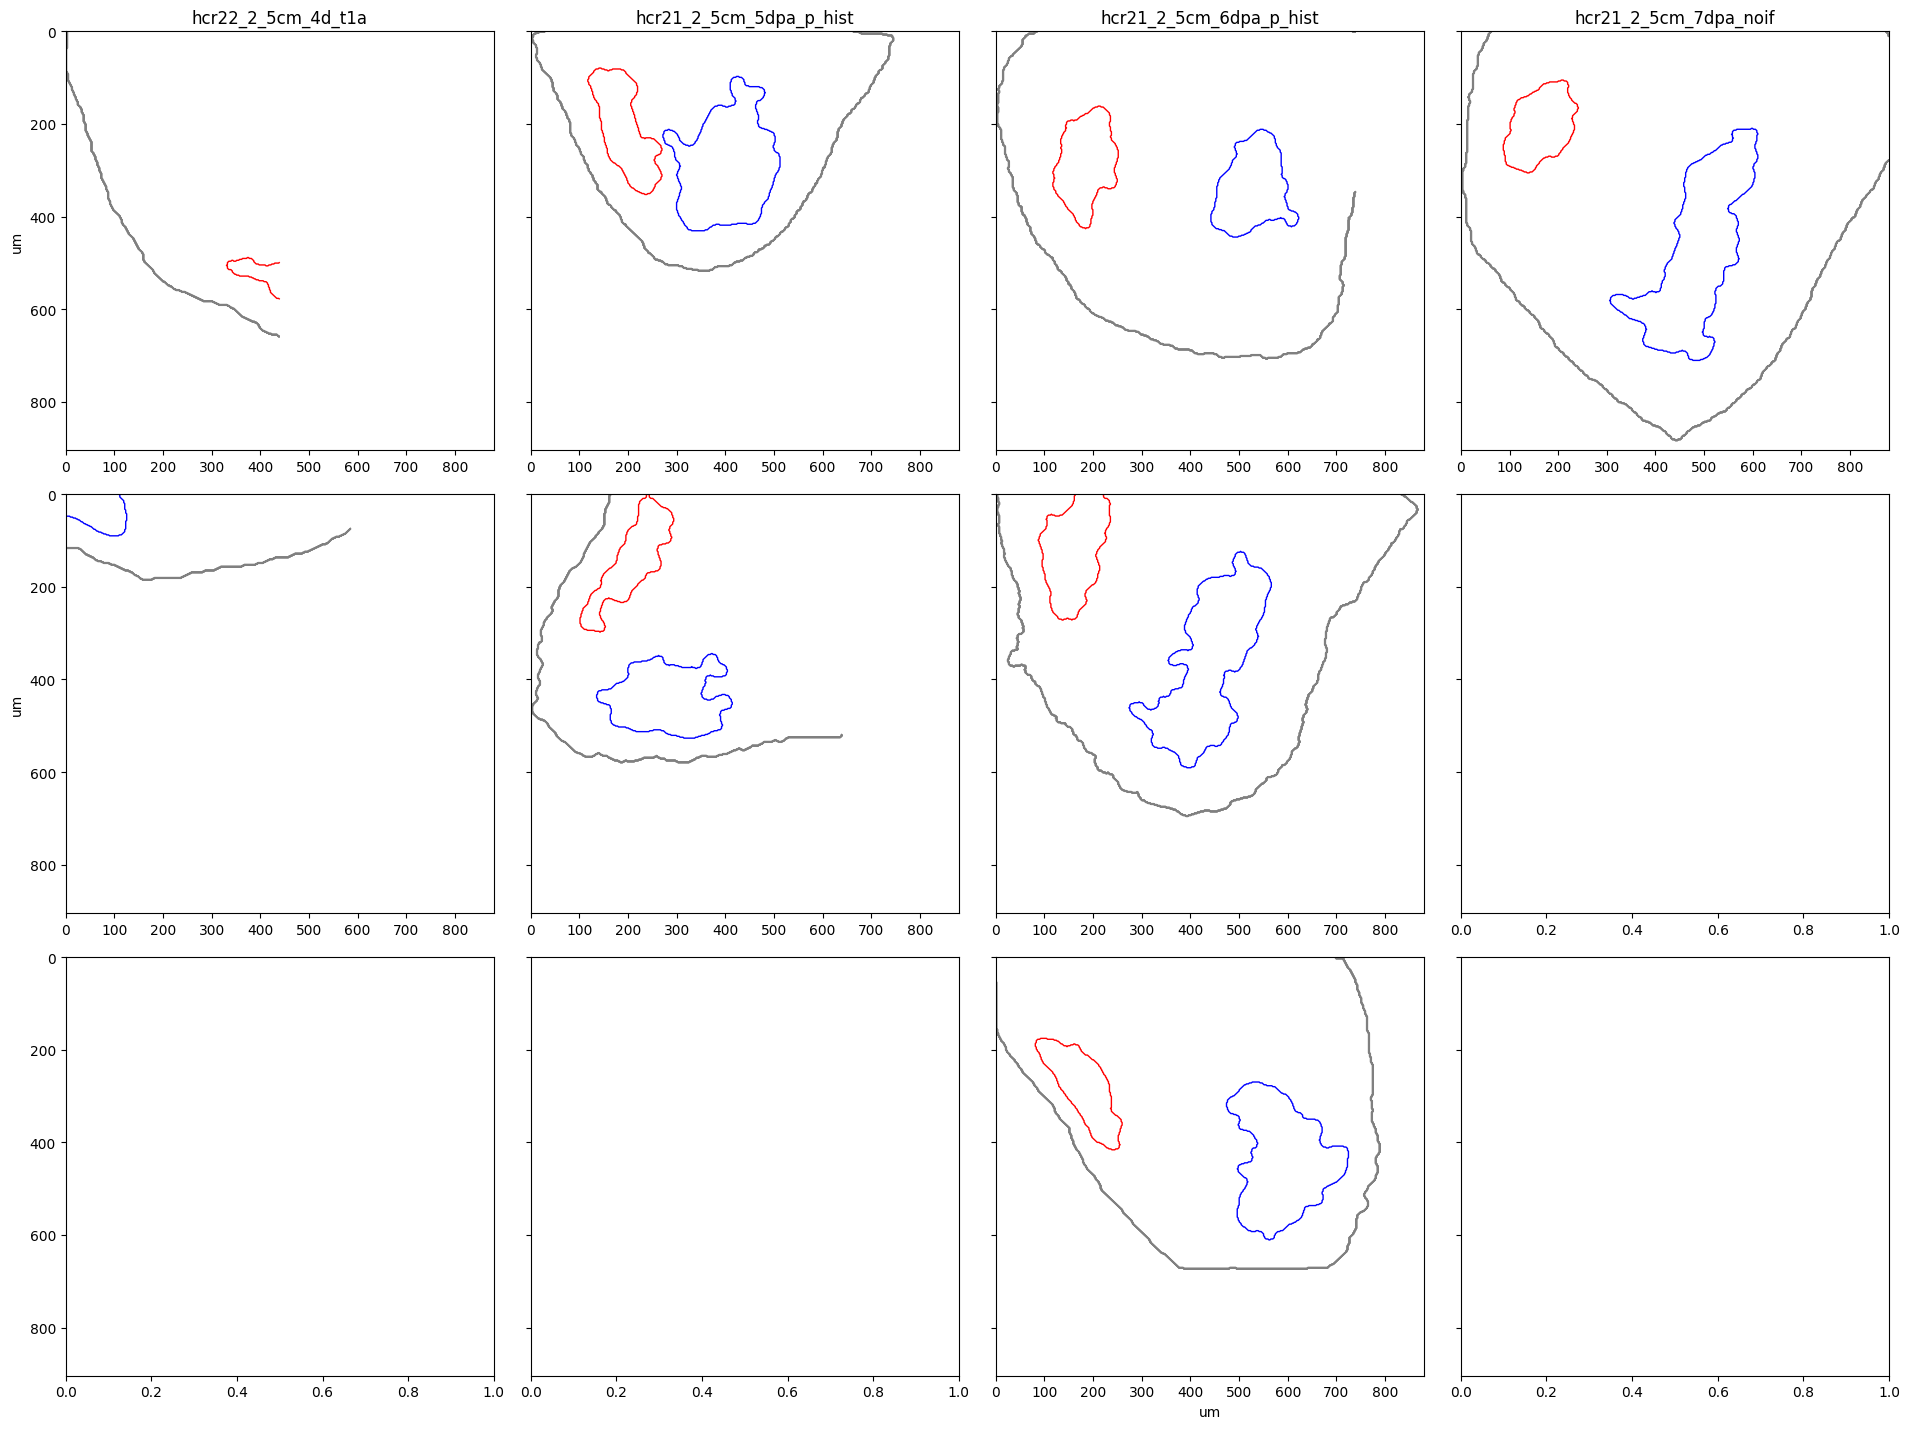

In [27]:
nrows = 3
ncols = len( img.keys() )
            
           
figsize_y, fig_size = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*fig_size, nrows*fig_size), sharex=False, sharey=True)
         
i = 0
for tkey in tkeys:
    for nkey in img[tkey].keys():
        for file_name in img[tkey][nkey].keys():        
            # have to think about this condition to get right plots positions
            j = (int(nkey) - 1) * ncols + (i + 1)
            ax = plt.subplot(nrows, ncols, j)
    
            tnmask = img[tkey][nkey][file_name]['tissue_mask_with_epi']
            tnmask_shh = mask.largest_component( binary_fill_holes( binary_closing( binary_opening( (img[tkey][nkey][file_name][shh_morph]>0).astype(np.uint8), selem ), selem ) ) )
            tnmask_fgf = mask.largest_component( binary_fill_holes( binary_closing( binary_opening( (img[tkey][nkey][file_name][fgf_morph]>0).astype(np.uint8), selem ), selem ) ) )
             
            ax.contour(tnmask, linewidths=1, colors='gray',  extent=[0, tnmask.shape[1]*pixel_size, 0, tnmask.shape[0]*pixel_size])
            ax.contour(tnmask_shh, linewidths=1, colors='red',  extent=[0, tnmask.shape[1]*pixel_size, 0, tnmask.shape[0]*pixel_size])
            ax.contour(tnmask_fgf, linewidths=1, colors='blue',  extent=[0, tnmask.shape[1]*pixel_size, 0, tnmask.shape[0]*pixel_size])
            
            title = file_name

            ax.set_xlim(0, x_lim * pixel_size)
            ax.set_ylim(y_lim * pixel_size, 0)
            if j < ncols + 1:
                ax.set_title(title )
            if j > ncols*nrows - ncols:
                ax.set_xlabel( 'um')
            if (j-1)%ncols == 0:
                ax.set_ylabel( 'um')
            ax.axis('on')
        
    i = i + 1

plt.tight_layout()

## Align to reference: similarity transform

NAME / TTYPE        FUNCTION PARAMETERS

'euclidean'         `src, `dst`

'similarity'        `src, `dst`

'affine'            `src, `dst`

'piecewise-affine'  `src, `dst`

'projective'        `src, `dst`

'polynomial'        `src, `dst`, `order` (polynomial order,
                                          default order is 2)

In [28]:
ref_for_times = ['1', '1', '2', '1']

In [29]:
from skimage.transform import estimate_transform
from skimage.transform import warp
from skimage.draw import polygon
from scipy.interpolate import interp1d

In [30]:
tnmask = img[tkey][nkey][file_name]['tissue_mask_with_epi']
tnmask_shh = mask.largest_component( binary_fill_holes( binary_closing( binary_opening( (img[tkey][nkey][file_name][shh_morph]>0).astype(np.uint8), selem ), selem ) ) )
tnmask_fgf = mask.largest_component( binary_fill_holes( binary_closing( binary_opening( (img[tkey][nkey][file_name][fgf_morph]>0).astype(np.uint8), selem ), selem ) ) )

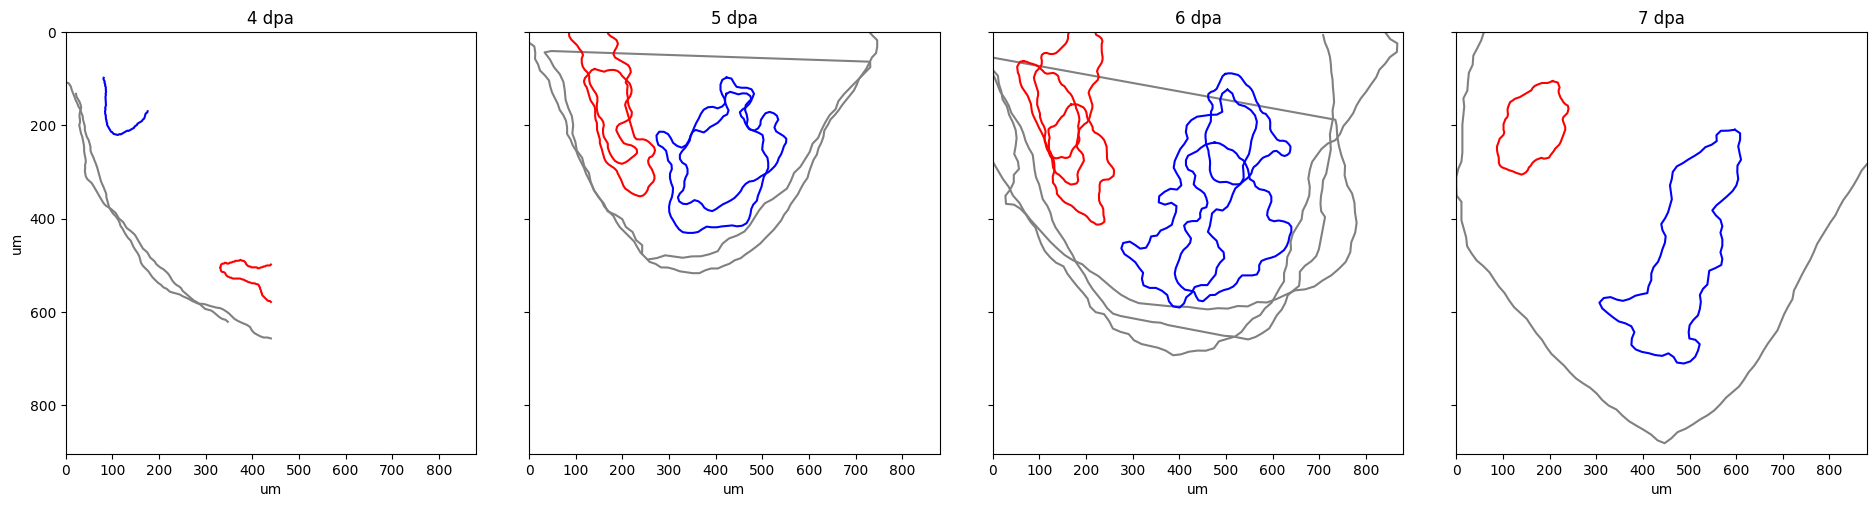

In [31]:
nrows = 1
ncols = len( img.keys() )
            
           
figsize_y, fig_size = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*fig_size, nrows*fig_size), sharex=False, sharey=True)
         
i = 0
for tkey in tkeys:
    for file_name in img[tkey][ref_for_times[i]].keys():        
        ref_mask = img[tkey][ ref_for_times[i] ][file_name]['tissue_mask']
    vert_ref = take_contour_vert_from_mask( ref_mask )

    for nkey in img[tkey].keys():
        for file_name in img[tkey][nkey].keys():
            # have to think about this condition to get right plots positions
            j = (i + 1)
            ax = plt.subplot(nrows, ncols, j)
    
            ####### align masks ###########
            tnmask     = img[tkey][nkey][file_name]['tissue_mask']       
            tnvert     = take_contour_vert_from_mask( tnmask )

            tnvert_with_epi = take_contour_vert_from_mask( img[tkey][nkey][file_name]['tissue_mask_with_epi'] )
    
            # get transformation matrix
            tform = estimate_transform('euclidean', tnvert, vert_ref)
            tnvert_aligned = tform(tnvert)
            tnvert_with_epi_aligned = tform(tnvert_with_epi)

            #ax.plot( tnvert_aligned[:, 0], tnvert_aligned[:,1], color='gray' )
            ax.plot( tnvert_with_epi_aligned[:, 0], tnvert_with_epi_aligned[:,1], color='gray' )
    
            # apply transformation to shh, fgf
            if not np.all(img[tkey][nkey][file_name][shh_morph] == 0):
                tnmask_shh = (img[tkey][nkey][file_name][shh_morph]>0) * 1
                tnvert_shh = take_contour_vert_from_mask( tnmask_shh )
                tnvert_shh_aligned = tform(tnvert_shh)
                ax.plot( tnvert_shh_aligned[:, 0], tnvert_shh_aligned[:,1], color='red' )
                
            if not np.all(img[tkey][nkey][file_name][fgf_morph] == 0):
                tnmask_fgf = (img[tkey][nkey][file_name][fgf_morph]>0) * 1
                tnvert_fgf = take_contour_vert_from_mask( tnmask_fgf )
                tnvert_fgf_aligned = tform(tnvert_fgf)
                ax.plot( tnvert_fgf_aligned[:, 0], tnvert_fgf_aligned[:,1], color='blue' )
            
            title = tkey + ' dpa'
            ax.set_xlim(0, x_lim * pixel_size)
            ax.set_ylim(y_lim * pixel_size, 0)
            if j < ncols + 1:
                ax.set_title(title )
            if j > ncols*nrows - ncols:
                ax.set_xlabel('um')
            if (j-1)%ncols == 0:
                ax.set_ylabel('um')
            ax.axis('on')
            ax.set_aspect('equal')
        
    i = i + 1

plt.savefig('final/2_5cm_blastemas_overlay.pdf')
plt.tight_layout()